## マルコフ連鎖

:::{card} マルコフ連鎖（Markov chain）

ある時点$T$の確率変数$Y_T$の確率密度関数が、一期前の実現値$y_{t-1}$にのみ依存する、すなわち

$$
f(y_t|y_0,y_1,\cdots,y_{t-1}) = f(y_t|y_{t-1})
$$

を満たす確率過程を **マルコフ連鎖（Markov chain）** という。

:::

### 有限・離散での簡単な数値例

状態集合$\{A,B,C\}$があるとし、それぞれに遷移する確率を行列として表す

$$
P=\left(\begin{array}{lll}
0.1 & 0.6 & 0.3 \\
0.4 & 0.5 & 0.1 \\
0.2 & 0.3 & 0.5
\end{array}\right)
$$

（※実際のベイズ推定だと連続値のパラメータであり状態集合が無限で、明示的な遷移確率行列は出せない）

In [1]:
import numpy as np

# 遷移確率行列（行：現在, 列：次）
states = ["A", "B", "C"]
P = np.array([
    [0.1, 0.6, 0.3],
    [0.4, 0.5, 0.1],
    [0.2, 0.3, 0.5],
], dtype=float)

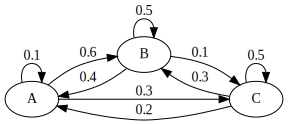

In [2]:
# -------------------------
# Graphvizで遷移図を描く
# -------------------------
from graphviz import Digraph
dot = Digraph("markov_chain", format="png")
dot.attr(rankdir="LR")

for s in states:
    dot.node(s, s)

for i, s_from in enumerate(states):
    for j, s_to in enumerate(states):
        p = P[i, j]
        # 0確率は描かない（見やすさ）
        if p > 0:
            dot.edge(s_from, s_to, label=f"{p:.1f}")
dot

In [3]:
# 遷移による確率の変化
p = np.array([0.1, 0.0, 0.0])  # 初期状態
for t in range(1, 3):
    p = p @ P
    print(f"{t=}, {p=}")

t=1, p=array([0.01, 0.06, 0.03])
t=2, p=array([0.031, 0.045, 0.024])


In [4]:
# 遷移による確率の変化（遷移核は事前に総積）
p = np.array([0.1, 0.0, 0.0])  # 初期状態
for t in [1, 2, 5, 10, 30, 100]:
    p_t = p @ np.linalg.matrix_power(P, t)
    print(f"t={t:3d} mu:", dict(zip(states, p_t.round(6))))

t=  1 mu: {'A': 0.01, 'B': 0.06, 'C': 0.03}
t=  2 mu: {'A': 0.031, 'B': 0.045, 'C': 0.024}
t=  5 mu: {'A': 0.026779, 'B': 0.047607, 'C': 0.025614}
t= 10 mu: {'A': 0.026829, 'B': 0.047561, 'C': 0.02561}
t= 30 mu: {'A': 0.026829, 'B': 0.047561, 'C': 0.02561}
t=100 mu: {'A': 0.026829, 'B': 0.047561, 'C': 0.02561}


定常分布$\pi$は

$$
\pi=\pi P, \quad \sum_i \pi_i=1
$$

を満たすベクトル。固有ベクトルで求めることもできる。

（ベイズ推定の場合、定常分布じゃなくサンプルがほしいのと、状態が離散じゃなく連続であり遷移確率行列が明示的に求まらないのでこの方法は使わない）

In [9]:
# -------------------------
# 定常分布を求める（固有ベクトル法）
# -------------------------
w, v = np.linalg.eig(P.T)  # P^T の固有分解
idx = np.argmin(np.abs(w - 1.0))  # 固有値1に最も近いもの
pi = np.real(v[:, idx])
pi = pi / pi.sum()  # 正規化
pi = np.maximum(pi, 0)  # 数値誤差で微小負になるのを対策
pi = pi / pi.sum()

print("stationary pi:", dict(zip(states, pi.round(6))))

stationary pi: {'A': 0.268293, 'B': 0.47561, 'C': 0.256098}


In [10]:
# -------------------------
# 状態列サンプリング（経験分布）
# -------------------------
rng = np.random.default_rng(0)

def simulate_chain(P, start_state, T):
    x = start_state
    xs = [x]
    for _ in range(T):
        x = rng.choice(len(states), p=P[x])
        xs.append(x)
    return np.array(xs)

T = 200000
xs = simulate_chain(P, start_state=0, T=T)  # 0 = "A"
counts = np.bincount(xs, minlength=len(states))
emp = counts / counts.sum()

print("empirical:", dict(zip(states, emp.round(6))))
print("stationary:", dict(zip(states, pi.round(6))))


empirical: {'A': 0.269089, 'B': 0.475783, 'C': 0.255129}
stationary: {'A': 0.268293, 'B': 0.47561, 'C': 0.256098}
